# Architecture analysis at node scale

## Module requierement

### Import standard module python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Import strawberry modules

In [2]:
import openalea.strawberry #import openalea.strawberry module
from openalea.strawberry.import_mtgfile import import_mtgfile, plant_number_by_varieties
from openalea.strawberry.analysis import extract_at_node_scale,prob_axillary_production

## Import  and read mtg files

* Import and read mtg file for each varieties

In [3]:
Gariguette = import_mtgfile(filename= "Gariguette")
Capriss = import_mtgfile(filename = "Capriss")
Darselect = import_mtgfile(filename = "Darselect")
Cir107 = import_mtgfile(filename = "Cir107")
Ciflorette = import_mtgfile(filename = "Ciflorette")
Clery = import_mtgfile(filename="Clery")

* Import and read mtg for the varities Gariguette and Capriss in the single big mtg file

In [4]:
All_varieties = import_mtgfile(filename=["Gariguette","Capriss","Darselect","Cir107","Ciflorette", "Clery"])
plant_number_by_varieties(All_varieties)

Darselect : 54 plants
Gariguette : 54 plants
Clery : 54 plants
Ciflorette : 54 plants
Capriss : 54 plants
Cir107 : 54 plants


## Extraction of data at node scale

This section shows how to extract node scale data as a dataframe using extract_at_node_scale

In [6]:
df_node_Gar = extract_at_node_scale(Gariguette)


784

## Analysis at node scale

In this section you will find the available analyses at node scale and associated plots. 

Currently, only the analysis of axillary production propability as function of node rank is possible. 

* **probability of axillary production** according to node rank allows to identify the probability of having a stolon (S), vegetative bud (VB), initiated bud (IB), floral bud (FB), aborted,rotten or dried bud (AB) and branch crown (BC) for each node. This function allows to calculate the probability for all orders but also by orders according to the sympodial way from main crown 

In [9]:
prob_axillary_production(Gariguette,order=0,plot=False)


branching_type,AB,BC,FB,IB,S,VB
rank,,,,,,
1,0.203704,0.111111,0.351852,0.018519,0.296296,0.018519
2,0.111111,0.037037,0.574074,0.037037,0.166667,0.074074
3,0.148148,0.037037,0.574074,0.037037,0.092593,0.111111
4,0.188679,0.075472,0.603774,0.037736,0.037736,0.056604
5,0.094340,0.132075,0.660377,0.056604,0.000000,0.056604
6,0.056604,0.037736,0.660377,0.037736,0.037736,0.169811
7,0.056604,0.169811,0.471698,0.132075,0.018868,0.150943
8,0.038462,0.269231,0.480769,0.057692,0.019231,0.134615
9,0.022222,0.355556,0.488889,0.044444,0.000000,0.088889


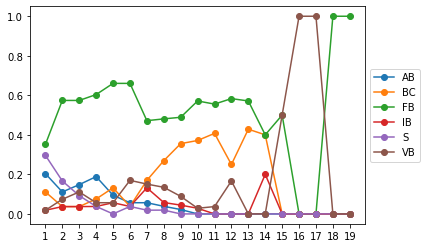

In [7]:
prob_axillary_production(Gariguette,order=0,plot=True)